In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 15 # Fixing the seed for PRNGs, to help reproducibility
np.random.seed(seed)
tf.random.set_seed(seed)



## Preparing the Dataset

We dedicated the previous [notebook](./ch6_nb4_data_preparation_for_smart_car_apps.ipynb) to setting up the input pipeline for the Cityscapes data[$^1$](#ref). It is now just a matter of importing our helper functions and instantiate our `tf.data.Dataset` accordingly: 

In [2]:
from cityscapes_utils import (
    CITYSCAPES_FOLDER, # change this variable to Cityscapes root folder
    CITYSCAPES_LABELS, CITYSCAPES_IGNORE_VALUE, 
    cityscapes_input_fn, get_cityscapes_file_pairs, 
    postprocess_to_show)

In [3]:
# Key variables:
batch_size     = 16
num_epochs     = 90
image_size     = [512, 512]
num_channels   = 3
num_classes    = len(CITYSCAPES_LABELS)
random_seed    = 1
num_show       = 3

In [5]:
print(CITYSCAPES_LABELS)

[Label(name='road', id=7, trainId=0, category='flat', categoryId=1, hasInstances=False, ignoreInEval=False, color=(128, 64, 128)), Label(name='sidewalk', id=8, trainId=1, category='flat', categoryId=1, hasInstances=False, ignoreInEval=False, color=(244, 35, 232)), Label(name='building', id=11, trainId=2, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(70, 70, 70)), Label(name='wall', id=12, trainId=3, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(102, 102, 156)), Label(name='fence', id=13, trainId=4, category='construction', categoryId=2, hasInstances=False, ignoreInEval=False, color=(190, 153, 153)), Label(name='pole', id=17, trainId=5, category='object', categoryId=3, hasInstances=False, ignoreInEval=False, color=(153, 153, 153)), Label(name='traffic light', id=19, trainId=6, category='object', categoryId=3, hasInstances=False, ignoreInEval=False, color=(250, 170, 30)), Label(name='traffic sign', id=20, tra

In [ ]:
num_train_imgs = len(get_cityscapes_file_pairs(split='train', 
                                               root_folder=CITYSCAPES_FOLDER)[0])
num_val_imgs   = len(get_cityscapes_file_pairs(split='val', 
                                               root_folder=CITYSCAPES_FOLDER)[0])

train_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=True, num_epochs=num_epochs, augment=True, seed=random_seed)
val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=batch_size,
    shuffle=False, num_epochs=1, augment=False, seed=random_seed)

For visualization purpose, we also create a validation dataset using the images with blurred faces/immatriculation plates (for privacy). <br> we only create the `tf.data.Dataset` to grab one batch:

In [5]:
visual_val_dataset = cityscapes_input_fn(
    root_folder=CITYSCAPES_FOLDER, resize_to=image_size, batch_size=num_show,
    shuffle=True, num_epochs=1, augment=False, seed=random_seed, blurred=True)

val_image_samples, val_gt_samples = next(visual_val_dataset.__iter__())
del visual_val_dataset

segmentation_input_fn False


In [6]:
import math

# Number of batches per train/val epoch, to guide the Keras `fit` method:
train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

## Building a FCN-8s Model for Semantic Segmentation

we presented the **_FCN_ architectures** and train it to segment our urban images:

### FCN-8s architecture

_FCN_ models have been developed for semantic segmentation. Based on **_VGG-16_**[$^3$](#ref), they use this network as _feature extractor_, adding on top some layers to concatenate and upsample the feature maps into pixel-level predictions.

To purely focus on the architecture, we will once again use the Keras high-level API to create our model:

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *

In [8]:
# Network hyper-parameters:
kernel_size    = 4
filters_orig   = 32
layer_depth    = 4
use_batch_norm = batch_size > 1

The _FCN_ architecture is as follow (c.f. details in Chapter 6):

![FCN Architecture](./notebook_images/fcn.png)

Using the pre-trained _VGG-16_ network provided by Keras, we extend at according to this figure:

In [9]:
def fcn_8s(image_size, ch_in=3, ch_out=3):
    """
    Build a FCN-8s Keras model, with the VGG-16 layers pretrained on ImageNet.
    :param image_size:  Image size (H x W)
    :param ch_in:       Number of input channels
    :param ch_out:      Number of output channels
    :return:            Keras model
    """
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  # shape: (28, 28, 256)
    f4 = vgg16.get_layer('block4_pool').output  # shape: (14, 14, 512)
    f5 = vgg16.get_layer('block5_pool').output  # shape: ( 7,  7, 512)

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5_conv3` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5_conv3)
    # Note: if your machine is not performant enough or if you want to run a lighter version,
    #       you can short-circuit the `f5_convX` layers and directy upscale `f5` instead:
    # f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
    #                             use_bias=False, padding='same', activation='relu')(f5)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation=None)(merge2)
    
    fcn8s_model = Model(inputs, outputs)
    return fcn8s_model

 We can now instantiate our model for semantic segmentation, i.e., returning $H \times W \times N$ tensors (with $H, W$ image size, $N$ the number of classes). For each pixel, the $N$ predicted values/logits represent the network's belief that this pixel belongs to the classes (the higher one of the values, the more probable the pixel belongs to the corresponding class according to the model).

In [10]:
fcn8s_model = fcn_8s(image_size, num_channels, num_classes)
fcn8s_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input[0][0]                      
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

### Loss and Metrics

We have the model and data ready. However before starting training, we will set up some additional visualization tools, and more importantly define our training loss.

Let us start with the loss.
As mentioned already, semantic segmentation is nothing but **classification at the pixel-level** (instead of image-level). Therefore, the same loss function can be used: _**cross-entropy**_.

However, in our Cityscapes experiment, we decided to ignore some of the classes present in the label maps (i.e., the misc. classes with `trainID != 255` c.f. previous notebook). We have therefore two choices: 

- Either we consider all the ignored elements as belonging to a 20th `void` class, and ask the network to correctly assign the corresponding pixels to the 20th class;
- Or we completely ignore the corresponding pixels, and do not penalize our network for misclassifying them.

The Cityscapes [benchmarks](https://www.cityscapes-dataset.com/benchmarks/) evaluate models based on the second strategy, so will we.

To do so, before computing the cross-entropy, we will process our predictions and ground-truths to **mask out the pixels belonging to the ignored classes** in the ground-truth maps. This is the purpose of the function `prepare_data_for_loss()` below, which builds a mask of valid pixels from the ground-truth maps, and then uses that mask to keep only these pixels in both tensors:

In [11]:
def get_mask_for_valid_labels(y_true, num_classes, ignore_value=255):
    """
    Build a mask for the valid pixels, i.e. those not belonging to the ignored classes.
    :param y_true:        Ground-truth label map(s) (each value represents a class trainID)
    :param num_classes:   Total nomber of classes
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none)
    :return:              Binary mask of same shape as `y_true`
    """
    mask_for_class_elements = y_true < num_classes
    mask_for_not_ignored = y_true != ignore_value
    mask = mask_for_class_elements & mask_for_not_ignored
    return mask


def prepare_data_for_segmentation_loss(y_true, y_pred, num_classes=10, ignore_value=255):
    """
    Prepare predicted logits and ground-truth maps for the loss, removing pixels from ignored classes.
    :param y_true:        Ground-truth label map(s) (e.g., of shape B x H x W)
    :param y_pred:        Predicted logit map(s) () (e.g., of shape B x H x W x N, N number of classes)
    :param num_classes:   Number of classes
    :param ignore_value:  trainID value of ignored classes (`None` if ignored none) 
    :return:              Tensors edited, ready for the loss computation
    """

    with tf.name_scope('prepare_data_for_loss'):
        # Flattening the tensors to simplify the following operations:
        if len(y_pred.shape) > (len(y_true.shape) - 1):
            y_pred = tf.reshape(y_pred, [-1, num_classes])
        else:
            y_pred = tf.reshape(y_pred, [-1])
        y_true = tf.reshape(tf.cast(y_true, tf.int32), [-1])

        if ignore_value is not None:
            # To compare only on the considered class, we remove all the elements in the images
            # belonging to the ignored ones.
            # For that, we first compute the mask of the pixels belonging to valid labels:
            mask_for_valid_labels = get_mask_for_valid_labels(
                y_true, num_classes, ignore_value=ignore_value)
    
            # Then we use this mask to remove all pixels/elements not belonging to valid classes:
            y_true = tf.boolean_mask(y_true, mask_for_valid_labels, axis=0, name='gt_valid')
            y_pred = tf.boolean_mask(y_pred, mask_for_valid_labels, axis=0, name='pred_valid')

    return y_true, y_pred

To be able to apply this pre-processing before computing the loss, we implement our own custom loss function. The cross-entropy is computed as usual, but only after applying the method we just built:

In [12]:
class SegmentationLoss(tf.losses.SparseCategoricalCrossentropy):
    def __init__(self, ignore_value=CITYSCAPES_IGNORE_VALUE, 
                 from_logits=False, reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE, name='loss'):
        super().__init__(from_logits=from_logits, reduction=reduction, name=name)
        self.ignore_value = ignore_value
    
    def _prepare_data(self, y_true, y_pred):
        num_classes = y_pred.shape[-1]
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=num_classes, 
                                                            ignore_value=self.ignore_value)
        return y_true, y_pred
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = self._prepare_data(y_true, y_pred)
        loss = super().__call__(y_true, y_pred, sample_weight)
        return loss

Similarly, if we want to compute the accuracy as metric (i.e., the percent of correctly classified pixels), we need to edit the default method to ignore the pixels belonging to our misc. classes:

In [13]:
class SegmentationAccuracy(tf.metrics.Accuracy):
    def __init__(self, ignore_value=CITYSCAPES_IGNORE_VALUE, name='acc', dtype=None):
        super().__init__(name=name, dtype=dtype)
        self.ignore_value = ignore_value

    def __call__(self, y_true, y_pred, sample_weight=None):
        num_classes = y_pred.shape[-1]
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=num_classes, 
                                                            ignore_value=self.ignore_value)
        # And since tf.metrics.Accuracy needs the label maps, not the one-hot versions,
        # we adapt accordingly:
        y_pred = tf.argmax(y_pred, axis=-1)
        
        return super().__call__(y_true, y_pred, sample_weight)

Additionally, we will also implement the _**Intersection-over-Union (IoU)**_ metric. Unlike the accuracy above, the _IoU_ does not under-represent classes which are covering smaller areas in the images (c.f. Chapters 5 and 6).

Luckily for us, TensorFlow has its own implementation of the mean _IoU_ (_IoU_ for multi-class predictions, averaging the _IoU_ computed for each clas separately). Once again, we simply edit this loss to take into account our ignored classes:

In [14]:
class SegmentationMeanIoU(tf.metrics.MeanIoU):
    def __init__(self, num_classes, ignore_value=CITYSCAPES_IGNORE_VALUE, name='mIoU', dtype=None):
        super().__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.ignore_value = ignore_value
        self.num_classes = num_classes

    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true, y_pred = prepare_data_for_segmentation_loss(y_true, y_pred,
                                                            num_classes=self.num_classes, 
                                                            ignore_value=self.ignore_value)
        # And since tf.metrics.mean_iou() needs the label maps, not the one-hot versions,
        # we adapt accordingly:
        y_pred = tf.argmax(y_pred, axis=-1)
        
        return super().__call__(y_true, y_pred, sample_weight)  

### Other training helpers

To visualize some samples before/after training, we build a method to predict and post-process the results. This means **converting the logit maps into probabilities** (`softmax`), **selecting the most probable class for each pixel** (`argmax`), then **converting the predicted label maps into RGB label images for visualization**. We also process the input images and target labels (e.g. scaling them back to normal):

In [15]:
from plot_utils import plot_image_grid

def predict_and_postprocess(images, gt_labels):
    """
    Use the model to predict the label map, and post-process the data for visualization.
    :param images:      Images
    :param gt_labels:   Ground-truth label maps
    :return:            Images, predicted label maps and GT label maps ready for display
    """

    predicted_onehot = fcn8s_model(images)

    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted = tf.math.argmax(predicted_onehot, axis=-1)
    predicted = tf.expand_dims(predicted, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        images, predicted, gt_labels, one_hot=True)
    
    return images_show, predicted_show, gt_show

/home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


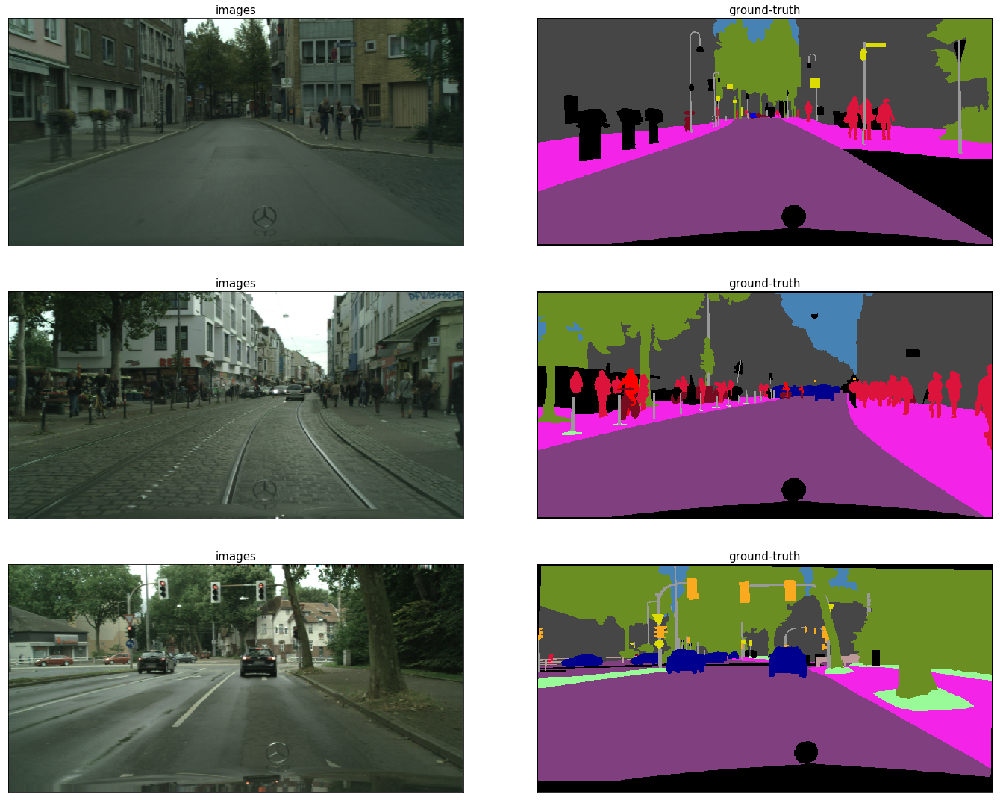

In [16]:
# Simply visualizing the input/target pairs for now:
image_show, predicted_show, gt_show = predict_and_postprocess(val_image_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), gt_show.numpy()], 
                         titles=["images", "ground-truth"])
figure.show()

Finally, we prepare some **callbacks** for the training, reusing the custom ones we previously created:

In [17]:
from keras_custom_callbacks import TensorBoardImageGridCallback

model_name = 'cityscapes_fcn8s'
model_dir = os.path.join('models', model_name)

def postprocess_for_grid_callback(input_images, predicted_images, gt_images):
    
    # We convert the predicted logits into categorical results
    # (i.e for each pixel, we assign the class corresponding to the largest logit/probability):
    predicted_images = tf.math.argmax(predicted_images, axis=-1)
    predicted_images = tf.expand_dims(predicted_images, axis=-1)

    # Then we post-process the tensors for display:
    images_show, predicted_show, gt_show = postprocess_to_show(
        input_images, predicted_images, gt_images, one_hot=True)

    return images_show, predicted_show, gt_show

# Callback to postprocess some validation results and display them in Tensorboard:
callback_tb_grid = TensorBoardImageGridCallback(
    log_dir=model_dir, 
    input_images=val_image_samples, target_images=val_gt_samples, 
    preprocess_fn=postprocess_for_grid_callback,
    tag=model_name + '_results', figsize=(15, 15))

<Figure size 4500x4500 with 0 Axes>

In [22]:
import collections
from keras_custom_callbacks import SimpleLogCallback

# Callback to simply log metrics at the end of each epoch (saving space compared to verbose=1):
metrics_to_print = collections.OrderedDict([("loss", "loss"), ("v-loss", "val_loss"),
                                            ("acc", "acc"), ("v-acc", "val_acc"),
                                            ("mIoU", "mIoU"), ("v-mIoU", "val_mIoU")])

callback_simple_log = SimpleLogCallback(metrics_to_print, num_epochs=num_epochs)

### Training

Each novel task we are tackling means a lot to set up before being able to start training. We are now thankfully ready to train our first model for semantic segmentation:

In [23]:
optimizer = tf.keras.optimizers.Adam()

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=model_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, 'weights-epoch{epoch:02d}-loss{val_loss:.2f}.h5'), period=5),
    # Callback to print compacted metrics at the end of each epoch:
    callback_simple_log,
    # Callback to log some validation results as image grids into TensorBoard:
    callback_tb_grid
]

fcn8s_model.compile(optimizer=optimizer, loss=SegmentationLoss(from_logits=True), 
                    metrics=[SegmentationAccuracy(), SegmentationMeanIoU(num_classes)])

history = fcn8s_model.fit(
    train_dataset,  epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=callbacks)

Training: start.
Epoch  0/90: loss = 1.302; v-loss = 0.800; acc = 0.596; v-acc = 0.750; mIoU = 0.106; v-mIoU = 0.156
Epoch  1/90: loss = 0.797; v-loss = 0.656; acc = 0.763; v-acc = 0.803; mIoU = 0.184; v-mIoU = 0.209
Epoch  2/90: loss = 0.611; v-loss = 0.496; acc = 0.818; v-acc = 0.849; mIoU = 0.230; v-mIoU = 0.256
Epoch  3/90: loss = 0.522; v-loss = 0.441; acc = 0.845; v-acc = 0.868; mIoU = 0.266; v-mIoU = 0.291
Epoch  4/90: loss = 0.473; v-loss = 0.405; acc = 0.859; v-acc = 0.878; mIoU = 0.290; v-mIoU = 0.318
Epoch  5/90: loss = 0.428; v-loss = 0.370; acc = 0.871; v-acc = 0.888; mIoU = 0.318; v-mIoU = 0.333
Epoch  6/90: loss = 0.394; v-loss = 0.353; acc = 0.880; v-acc = 0.892; mIoU = 0.341; v-mIoU = 0.359
Epoch  7/90: loss = 0.384; v-loss = 0.339; acc = 0.883; v-acc = 0.894; mIoU = 0.355; v-mIoU = 0.374
Epoch  8/90: loss = 0.362; v-loss = 0.336; acc = 0.889; v-acc = 0.898; mIoU = 0.375; v-mIoU = 0.390
Epoch  9/90: loss = 0.358; v-loss = 0.315; acc = 0.890; v-acc = 0.903; mIoU = 0.384

Epoch 41/90: loss = 0.222; v-loss = 0.217; acc = 0.928; v-acc = 0.930; mIoU = 0.577; v-mIoU = 0.571
Epoch 42/90: loss = 0.227; v-loss = 0.195; acc = 0.927; v-acc = 0.936; mIoU = 0.576; v-mIoU = 0.617
Epoch 43/90: loss = 0.222; v-loss = 0.203; acc = 0.928; v-acc = 0.935; mIoU = 0.576; v-mIoU = 0.577
Epoch 44/90: loss = 0.216; v-loss = 0.189; acc = 0.930; v-acc = 0.938; mIoU = 0.593; v-mIoU = 0.627
Epoch 45/90: loss = 0.212; v-loss = 0.190; acc = 0.931; v-acc = 0.938; mIoU = 0.601; v-mIoU = 0.625
Epoch 46/90: loss = 0.212; v-loss = 0.190; acc = 0.932; v-acc = 0.938; mIoU = 0.601; v-mIoU = 0.604
Epoch 47/90: loss = 0.225; v-loss = 0.221; acc = 0.928; v-acc = 0.929; mIoU = 0.586; v-mIoU = 0.538
Epoch 48/90: loss = 0.220; v-loss = 0.215; acc = 0.929; v-acc = 0.931; mIoU = 0.589; v-mIoU = 0.577
Epoch 49/90: loss = 0.222; v-loss = 0.188; acc = 0.928; v-acc = 0.939; mIoU = 0.592; v-mIoU = 0.629
Epoch 50/90: loss = 0.208; v-loss = 0.187; acc = 0.933; v-acc = 0.938; mIoU = 0.605; v-mIoU = 0.623


Epoch 82/90: loss = 0.179; v-loss = 0.162; acc = 0.941; v-acc = 0.946; mIoU = 0.669; v-mIoU = 0.682
Epoch 83/90: loss = 0.180; v-loss = 0.172; acc = 0.941; v-acc = 0.943; mIoU = 0.667; v-mIoU = 0.661
Epoch 84/90: loss = 0.178; v-loss = 0.165; acc = 0.942; v-acc = 0.946; mIoU = 0.668; v-mIoU = 0.679
Epoch 85/90: loss = 0.195; v-loss = 0.178; acc = 0.936; v-acc = 0.941; mIoU = 0.637; v-mIoU = 0.642
Epoch 86/90: loss = 0.204; v-loss = 0.165; acc = 0.934; v-acc = 0.945; mIoU = 0.632; v-mIoU = 0.682
Training: end.


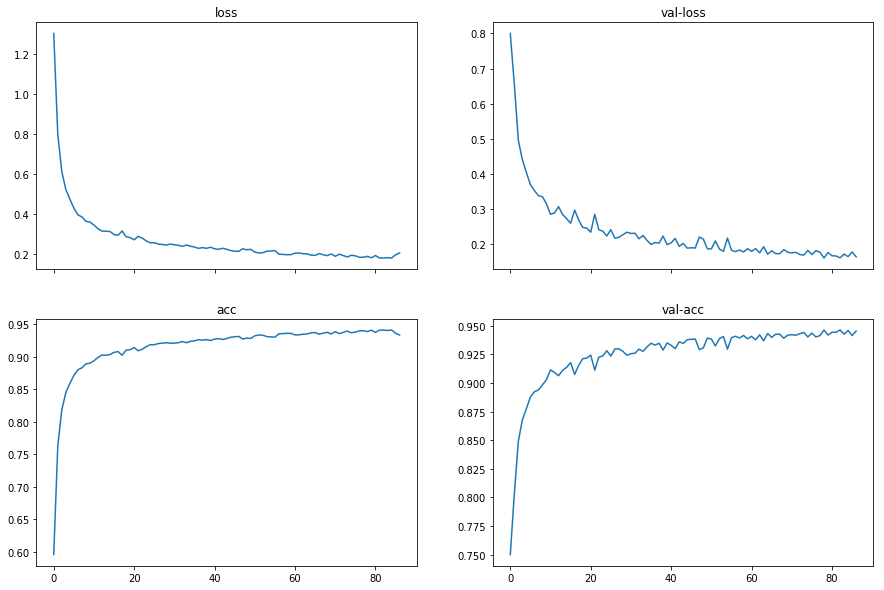

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex='col')
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")

ax[0, 0].plot(history.history['loss'])
ax[0, 1].plot(history.history['val_loss'])
ax[1, 0].plot(history.history['acc'])
ax[1, 1].plot(history.history['val_acc'])

***Note:*** It looks like our model could benefit from some additional epochs, as the accuracy seemed to still be slightly increasing. For our current demonstration, we will still stop the training here.

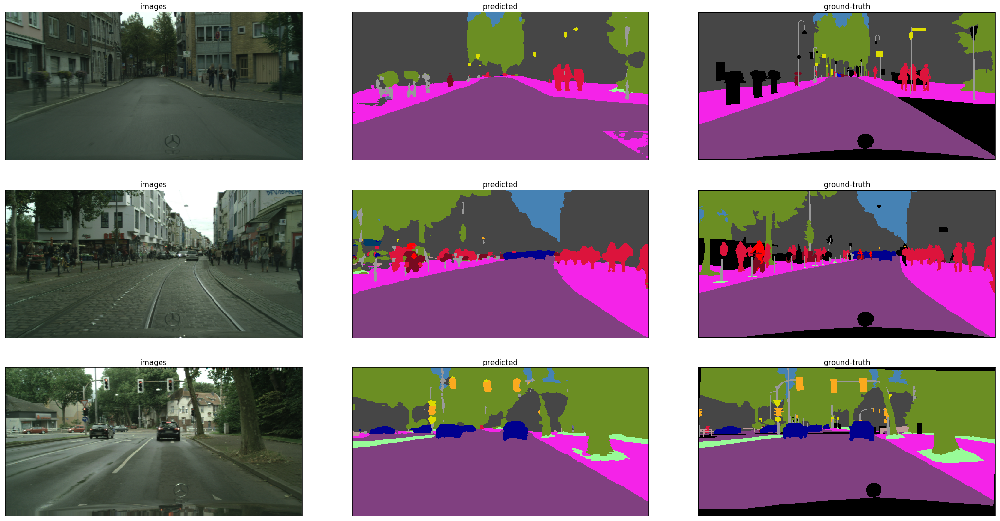

In [26]:
image_show, predicted_show, gt_show = predict_and_postprocess(val_image_samples, val_gt_samples)

figure = plot_image_grid([image_show.numpy(), predicted_show.numpy(), gt_show.numpy()], 
                         titles=["images", "predicted", "ground-truth"])
figure.show()